In [ ]:
import os
from pathlib import Path
from IPython.display import Image, display
os.chdir("/Users/oliverdaniels-koch/projects/elk-experiments")
out_dir = Path("output")
device = "mps"

In [ ]:
# train detector
import os
from functools import partial
from pathlib import Path
import torch
from cupbearer import tasks, detectors, scripts, utils
from cupbearer.detectors import ActivationCache
from cupbearer.detectors.statistical import MahalanobisDetector
from elk_experiments.utils import train_detector_cache
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset, task_data_to_dicts
from elk_experiments.eap_detector import EAPDetector, layer_edge_filter

In [ ]:
class EAPMahalanobisDetector(EAPDetector, MahalanobisDetector):
    pass

In [ ]:
task = tasks.tiny_natural_mechanisms("hex", "mps", "pythia-70m")
small_task = get_task_subset(task, 2048, 1024, 1024)
small_task = task_data_to_dicts(small_task)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  mps


In [ ]:
# TODO: look back at edge attribution example
task.model.set_use_split_qkv_input(True)
task.model.set_use_attn_result(True)
task.model.set_use_hook_mlp_in(True)

In [ ]:
# use mean probability over effect tokens as metric 
def effect_prob_func(logits, inputs):
    assert logits.ndim == 3
    assert inputs["completion_token"].shape[0] == logits.shape[0]
    # Sum over vocab and batch dim (for now we're just computing attribution values, we'll deal with per data instance later)
    probs = logits[:, -1, :].softmax(dim=-1)
    out = probs[:, inputs["completion_token"]].mean(dim=-1).mean() # mean over effect tokens, mean over batch
    # out = logits[:, -1, effect_tokens].mean()
    return out

In [ ]:
detector_dir = out_dir / "pythia-70m_hex_completion_token"

In [ ]:
detector = EAPMahalanobisDetector(
    effect_prob_func=effect_prob_func,
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=lambda x: True,
    input_filter = lambda x: x["prefix_tokens"],
    layer_aggregation="mean"
)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-02 15:17:39.523 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([4032])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-02 15:21:42.895 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.5879
2024-07-02 15:21:42.896 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.5750


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.5878582000732422,
               'AP': 0.5750469362797803}}),
 {'all': <Figure size 640x480 with 1 Axes>})

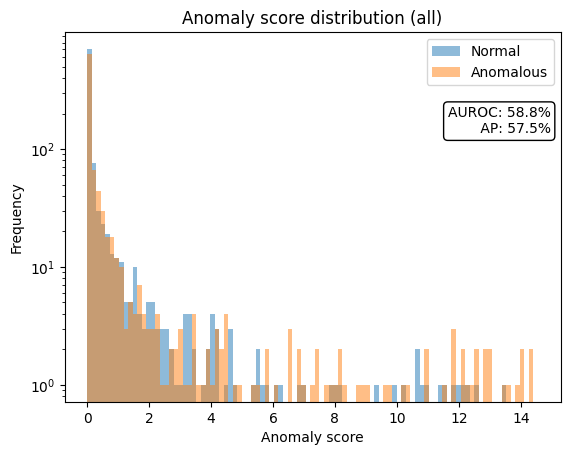

In [ ]:
train_detector_cache(
    detector_dir, 
    detector, 
    small_task, 
    batch_size=64, 
    eval_batch_size=64, 
    cache=None, 
    cache_path=None, 
    overwrite=True
)